In [3]:
import os
import time
import itertools

import numpy as np
import pandas as pd

import ipyvolume as ipv
from pathlib import Path

from tyssue import Sheet, config
from tyssue.io import hdf5
from tyssue.draw.ipv_draw import view_ipv
from tyssue.core.sheet import get_opposite
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.dynamics import effectors, units
from tyssue.solvers.sheet_vertex_solver import Solver


from invagination.ellipsoid import EllipsoidGeometry as geom
from invagination.ellipsoid import VitellineElasticity
from invagination.plots import (mesoderm_position,
                                panel_sagittal_view,
                               save_3_axis_plot,
                               save_ventral_plot)
from invagination.toolbox import (open_sheet,
                                  force_ratio,
                                  define_depth,
                                  define_time_max_depth,
                                  define_time_depth_compare_to_vivo,
                                 face_centered_patch)
from tyssue.draw.ipv_draw import sheet_view
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.cm as cmx

%matplotlib inline

SIM_DIR = Path('/media/admin-suz/Sophie/2018/Papiers-EMT-Melanie/datas/')

old = None

import seaborn as sns

In [57]:
dirname1 = SIM_DIR/'2018-09-09_TEST0'
list_dir1 = sorted(os.listdir(dirname1))
dirname2 = SIM_DIR/'2018-09-09_TEST1'
list_dir2 = sorted(os.listdir(dirname2))

['1.08_contractility_5_critical_area_30_radialtension_0',
 '1.08_contractility_5_critical_area_30_radialtension_1',
 '1.08_contractility_5_critical_area_30_radialtension_10',
 '1.08_contractility_5_critical_area_30_radialtension_11',
 '1.08_contractility_5_critical_area_30_radialtension_12',
 '1.08_contractility_5_critical_area_30_radialtension_13',
 '1.08_contractility_5_critical_area_30_radialtension_14',
 '1.08_contractility_5_critical_area_30_radialtension_15',
 '1.08_contractility_5_critical_area_30_radialtension_16',
 '1.08_contractility_5_critical_area_30_radialtension_17',
 '1.08_contractility_5_critical_area_30_radialtension_18',
 '1.08_contractility_5_critical_area_30_radialtension_19',
 '1.08_contractility_5_critical_area_30_radialtension_2',
 '1.08_contractility_5_critical_area_30_radialtension_3',
 '1.08_contractility_5_critical_area_30_radialtension_4',
 '1.08_contractility_5_critical_area_30_radialtension_5',
 '1.08_contractility_5_critical_area_30_radialtension_6',
 '1.

In [63]:
def define_depth_at_time_t (directory, t,  xmin=-20, xmax=20, ymin=-2, ymax=2):
    depth_0 = define_depth(directory, 0, ['z', 'x'], xmin, xmax, ymin, ymax)
    try:
        depth = (depth_0 - define_depth(directory, t, ['z', 'x'],
                                                 xmin, xmax, ymin, ymax))
    except Exception:
        depth = 0
        warnings.warn(
            'An error occured at time %i for directory %s', t, directory)
    return depth

data1_Ttime_depth_Ant = []
data1_Ttime_depth_Centr = []
for d in list_dir1:
    data1_Ttime_depth_Ant.append(define_depth_at_time_t(os.path.join(dirname1, d), 
                                                        t=50, xmin=-80, xmax = -70))
    data1_Ttime_depth_Centr.append(define_depth_at_time_t(os.path.join(dirname1, d), 
                                                        t=50, xmin=-5, xmax = 5))

data2_Ttime_depth_Ant = []
data2_Ttime_depth_Centr = []
for d in list_dir2: 
    data2_Ttime_depth_Ant.append(define_depth_at_time_t(os.path.join(dirname2, d), 
                                                        t=50, xmin=-80, xmax = -70))
    data2_Ttime_depth_Centr.append(define_depth_at_time_t(os.path.join(dirname2, d), 
                                                        t=50, xmin=-5, xmax = 5))

    
to_plot=[data1_Ttime_depth_Ant+ data2_Ttime_depth_Ant+
         data1_Ttime_depth_Centr + data2_Ttime_depth_Centr]

labels = [ 'depth']
df = pd.DataFrame.from_records(to_plot, labels)
df=df.transpose()
df['position'] = pd.Series(['Ant']*40+ ['Centr']*40)
df['state'] = pd.Series((['1-Ctl'] * 20 + ['2-Ablated'] * 20)*2)
df['stage'] = pd.Series(['Full'] * 80)

In [23]:
data1_full_depth_Ant=[]
data1_cup_depth_Ant=[]
data1_full_depth_Centr=[]
data1_cup_depth_Centr=[]
data1_full_depth_Ant_t=[]
data1_cup_depth_Ant_t=[]
data1_full_depth_Centr_t=[]
data1_cup_depth_Centr_t=[]

cpt = len(list_dir1)
for d in list_dir1:
    cpt = cpt-1
    
    t, depth = define_time_max_depth(os.path.join(dirname1, d), nb_t=200, xmin=-20, xmax = 20)
    data1_full_depth_Centr.append(depth)
    data1_full_depth_Centr_t.append(t)
    t, depth = define_time_depth_compare_to_vivo(os.path.join(dirname1, d), nb_t=200, in_vivo_depth = 5,
                                                 xmin=-20, xmax = 20)
    data1_cup_depth_Centr.append(depth)
    data1_cup_depth_Centr_t.append(t)
    
    
    t, depth = define_time_max_depth(os.path.join(dirname1, d), nb_t=200, xmin=-100, xmax = -60)
    data1_full_depth_Ant.append(depth)
    data1_full_depth_Ant_t.append(t)
    t, depth = define_time_depth_compare_to_vivo(os.path.join(dirname1, d), nb_t=200, in_vivo_depth = 5,
                                                 xmin=-100, xmax = -60)
    data1_cup_depth_Ant.append(depth)
    data1_cup_depth_Ant_t.append(t)

20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [24]:
data2_full_depth_Ant=[]
data2_cup_depth_Ant=[]
data2_full_depth_Centr=[]
data2_cup_depth_Centr=[]
data2_full_depth_Ant_t=[]
data2_cup_depth_Ant_t=[]
data2_full_depth_Centr_t=[]
data2_cup_depth_Centr_t=[]

cpt = len(list_dir2)
for d in list_dir2:
    cpt = cpt-1
    
    t, depth = define_time_max_depth(os.path.join(dirname2, d), nb_t=200, xmin=-20, xmax = 20)
    data2_full_depth_Centr.append(depth)
    data2_full_depth_Centr_t.append(t)
    t, depth = define_time_depth_compare_to_vivo(os.path.join(dirname2, d), nb_t=200, in_vivo_depth = 5,
                                                xmin=-20, xmax = 20)
    data2_cup_depth_Centr.append(depth)
    data2_cup_depth_Centr_t.append(t)
    
    t, depth = define_time_max_depth(os.path.join(dirname2, d), nb_t=200, xmin=-100, xmax = -60)
    data2_full_depth_Ant.append(depth)
    data2_full_depth_Ant_t.append(t)
    t, depth = define_time_depth_compare_to_vivo(os.path.join(dirname2, d), nb_t=200, in_vivo_depth = 5,
                                                xmin=-100, xmax = -60)
    data2_cup_depth_Ant.append(depth)
    data2_cup_depth_Ant_t.append(t)

20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [31]:
to_plot=[data1_cup_depth_Ant_t+ data2_cup_depth_Ant_t+
         data1_full_depth_Ant_t+ data2_full_depth_Ant_t + 
         data1_cup_depth_Centr_t+ data2_cup_depth_Centr_t+
         data1_full_depth_Centr_t+ data2_full_depth_Centr_t, 
         
         data1_cup_depth_Ant+ data2_cup_depth_Ant+
         data1_full_depth_Ant+ data2_full_depth_Ant + 
         data1_cup_depth_Centr+ data2_cup_depth_Centr+
         data1_full_depth_Centr+ data2_full_depth_Centr]

labels = ['t', 'depth']
df = pd.DataFrame.from_records(to_plot, labels)
df=df.transpose()
df['position'] = pd.Series(['Ant']*80 + ['Centr']*80)
df['stage'] = pd.Series((['Cup'] * 40 + ['Full'] * 40)*2)
df['state'] = pd.Series((['1-Ctl'] * 20 + ['2-Ablated'] * 20)*4)
df.to_csv('test0VStest1.csv')

In [31]:
#df = pd.read_csv('../test0VStest1.csv')
df.to_csv('test0VStest1.csv')

## Do Mann-Whitney or Wilcoxon test depending on experiments

In [65]:
# Mann-Whitney U test
# comparaison de datas non pairées
from scipy.stats import mannwhitneyu

# compare samples
stat, p = mannwhitneyu(df[(df['state']=='1-Ctl') & (df['stage']=='Full') & (df['position']=='Centr')]['depth'], 
                      df[(df['state']=='2-Ablated') & (df['stage']=='Full') & (df['position']=='Centr')]['depth'])
print('Statistics=%.3f, p=%.9f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')


Statistics=0.000, p=0.000000034
Different distribution (reject H0)


In [52]:
# Wilcoxon signed-rank test
# comparaison de datas pairées
from scipy.stats import wilcoxon, ranksums

# compare samples
stat, p = wilcoxon(df[(df['state']=='1-Ctl') & (df['stage']=='Full') & (df['position']=='Ant')]['depth'],
                    df[(df['state']=='1-Ctl') & (df['stage']=='Full') & (df['position']=='Centr')]['depth'])
print('Statistics=%.3f, p=%.7f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')
    
    
# compare samples
stat, p = wilcoxon(df[(df['state']=='2-Ablated') & (df['stage']=='Full') & (df['position']=='Ant')]['depth'],
                    df[(df['state']=='2-Ablated') & (df['stage']=='Full') & (df['position']=='Centr')]['depth'])
print('Statistics=%.3f, p=%.7f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

    


Statistics=0.000, p=0.0000886
Different distribution (reject H0)
Statistics=0.000, p=0.0000886
Different distribution (reject H0)


## Box plot

/home/admin-suz/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


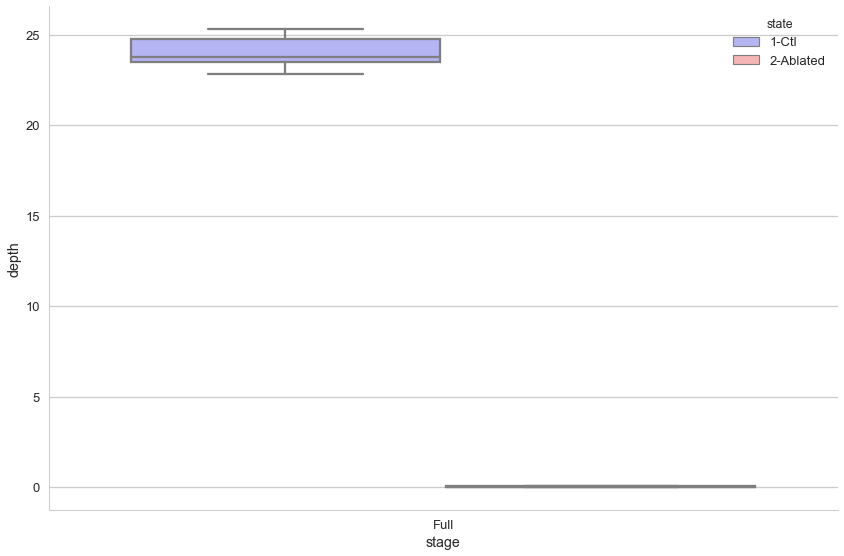

In [64]:
sns.set(context='talk', style='whitegrid')
fig = sns.factorplot(kind='box',        # Boxplot
               y='depth',       # Y-axis - values for boxplot
               x='stage',        # X-axis - first factor
               hue='state',         # Second factor denoted by color
               data=df[df['position']=='Centr'],        # Dataframe 
               size=8,            # Figure size (x100px)      
               aspect=1.5,        # Width = size * aspect 
               legend_out=False,
               palette='bwr') 


fig.savefig('../TEST0_VS_TEST1.svg',bbox_inches='tight')

/home/admin-suz/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:490: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



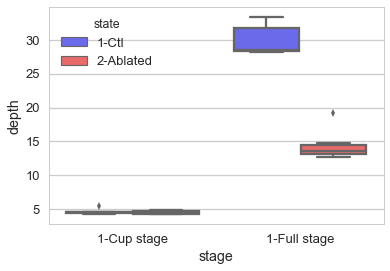

In [131]:
fig, ax = plt.subplots()
ax = sns.boxplot(x='stage', y='depth', hue='state', data= df, palette='seismic')
fig.savefig('../boxplot_NO_Ablation2.svg',bbox_inches='tight')